In [30]:
import pandas as pd
import pingouin as pg
import os, os.path as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import ticker

In [31]:
df = pd.read_csv(glob(op.join("data","Dane_Statystyka_Pełne*"))[0])

### Test t-Studenta dla prób niezależnych
 - Czy kraje małe i duże różnią się ilością spożywanego mięsa:

### Czy kraje duże oraz małe wykazują różnice w ilości spożywanego mięsa?
H0: Kraje małe i kraje duże nie różnią się ilością spożywanego mięsa.\
HA: Kraje małe i kraje duże różnią się ilością spożywanego mięsa.

In [32]:
pg.ttest((df[df["Wielkosc"] == "Duzy" ]["Spozycie miesa"]), (df[df["Wielkosc"] == "Maly" ]["Spozycie miesa"]))

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.707822,184,two-sided,0.007411,"[-23.09, -3.62]",0.397094,4.65,0.768436


##### t(184) = 2.71 ; p = 0.007 ; d = 0.4

- Wynik istotny statystycznie: p = 0.002.
- Występują różnice pomiędzy krajami dużymi i małymi (w zakresie ilości spożywanego mięsa).
- Efekty słaby.

In [33]:
df.groupby(['Wielkosc'])['Spozycie miesa'].agg([np.mean, np.std, np.min, np.max]).round(2)

,mean,std,amin,amax
Wielkosc,,,,
Duzy,38.24,32.01,3.1,124.8
Maly,51.59,35.19,3.0,145.9


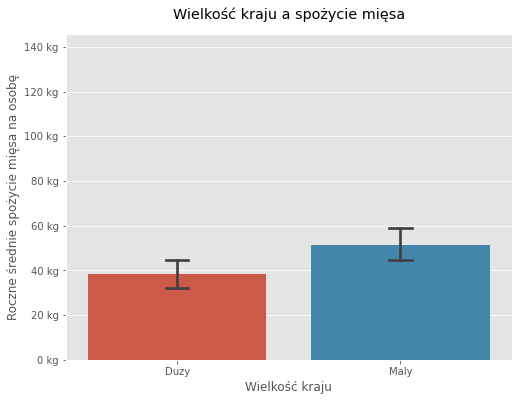

In [34]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x="Wielkosc", y="Spozycie miesa",data=df,
           order = ['Duzy','Maly'], capsize = .10)
ax.set_xlabel("Wielkość kraju")
ax.set_ylabel("Roczne średnie spożycie mięsa na osobę")
ax.set_ylim(0,146)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d kg"))

if not op.exists("plots"):
    os.mkdir("plots")

plt.title("Wielkość kraju a spożycie mięsa", pad = 15)
plt.savefig(fname=op.join("plots",'plot_tt.png'),dpi=600,transparent=False)
plt.show()



W celu sprawdzenia, czy kraje duże i małe kraje różnią sie ilościa spożywanego mięsa, wykonano analizę\
testem t Studenta dla prób niezależnych. Wynik tej analizy okazał się istotny statystycznie,\
t(184) = 2.71 ; p = 0.007; d = 0.4. Wynik d Cohena wskazuje na występowanie małego efektu\
wielkości. Kraje duże (M = 38.24 ; SD = 32.01) cechują się mniejszą ilością spożywanego\
mięsa od krajów małych (M = 51.59 ; SD = 35.19). Hipoteza badawcza potwierdziła się.


### ANOVA

Czy kontynent wpływa na średnie zaludnienie ?\

H0: Kontynent nie wpływa na średnie zaludnienie kraju (Os./Km^2).\
HA: Kontynent wpływa na średnie zaludnienie kraju (Os./Km^2).

In [35]:
df_a = df[(df["Kontynent"] == "Europe") | (df["Kontynent"] == "Africa") | (df["Kontynent"] == "Asia")].reset_index()

In [36]:
desc_a = df_a.groupby(["Kontynent"])["Wspolczynnik dzietności"].agg([np.mean, np.std, np.min, np.max, np.size]).round(2)
desc_a


,mean,std,amin,amax,size
Kontynent,,,,,
Africa,4.22,1.15,1.4,7.0,49
Asia,2.37,0.77,1.1,4.6,47
Europe,1.58,0.18,1.3,1.9,40


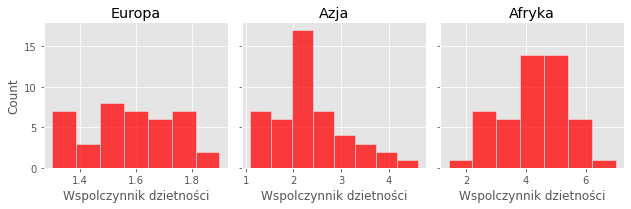

In [37]:
g = sns.FacetGrid(data=df_a, col="Kontynent", sharex = False, col_order = ["Europe","Asia","Africa"])
g.map_dataframe(sns.histplot, x="Wspolczynnik dzietności",color = "r",)
axes = g.axes.flatten()
axes[0].set_title("Europa")
axes[1].set_title("Azja")
axes[2].set_title("Afryka")
plt.savefig(fname=op.join("plots",'ANOVA.png'),dpi=600,transparent=False)

In [38]:
pg.anova(data=df_a, dv="Wspolczynnik dzietności", between="Kontynent")

,Source,ddof1,ddof2,F,p-unc,np2
0,Kontynent,2,133,120.441399,1.410017e-30,0.644274


#### F(2, 133) = 120.44 ; p < 0.001 ; etap2 = 0.64

- Wynik jest istotny statystycznie, kontynent wpływa na współczynnik dzietności.
- Odrzucamy H0.
- Etap2 = 0.64 --> efekt kontynentu jest silny.

In [39]:
pg.pairwise_tests(data=df_a, dv="Wspolczynnik dzietności", between="Kontynent", effsize="cohen",padjust='sidak').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,Kontynent,Africa,Asia,False,True,9.2842,84.4930,two-sided,0.0,0.0,sidak,7.73e+11,1.8806
1,Kontynent,Africa,Europe,False,True,15.8453,51.0292,two-sided,0.0,0.0,sidak,8.938e+23,3.0634
2,Kontynent,Asia,Europe,False,True,6.7790,52.0824,two-sided,0.0,0.0,sidak,5.702e+06,1.3560


In [40]:
df_a.groupby(["Kontynent"])["Wspolczynnik dzietności"].agg([np.mean, np.std, np.max]).round(2)

,mean,std,amax
Kontynent,,,
Africa,4.22,1.15,7.0
Asia,2.37,0.77,4.6
Europe,1.58,0.18,1.9


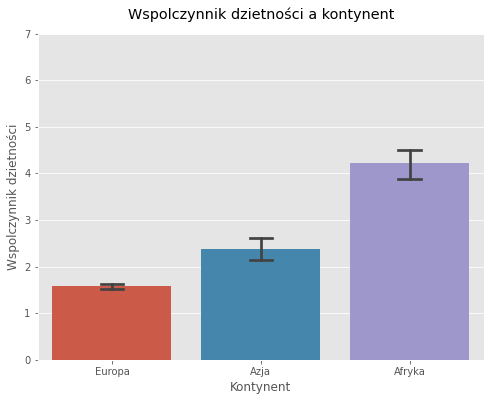

In [41]:
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x="Kontynent", y="Wspolczynnik dzietności",data=df_a,capsize = 0.15, order=  ["Europe","Asia","Africa"])
ax.set_xlabel("Kontynent")
ax.set_ylabel("Wspolczynnik dzietności")
ax.set_xticklabels(["Europa","Azja", "Afryka"])
ax.set_ylim(0, 7.0)
plt.title("Wspolczynnik dzietności a kontynent", pad = 15)
if not op.exists("plots"):
    os.mkdir("plots")
plt.savefig(op.join("plots","plot_ANOVA_2.png"),dpi=600, transparent=False)
plt.show()

W celu sprawdzenia, czy kontynent wpływa na współczynnik dzietności, wykonano jednoczynnikową analizę wariancji w schemacie międzygrupowym. Wynik tej analizy okazał się istotny statystycznie,
F(2, 133) = 120.44 ; p < 0.001 ; etap2 = 0.64. Wynik etap2 wskazuje na występowanie silnego efektu kontynentu. Porównania parami z korektą Sidaka wykazały istnienie istotnych statystycznie różnic między:

- Afryką a Azją (p < 0.001)
- Afryką a Europą (p < 0.001)
- Azją a Europą (p < 0.001)

Afryka (M = 4.21 ; SD = 1.15) posiada wyższy współczynnik dzietności od Azji (M = 2.37 ; SD = 0.77) oraz Europy (M= 1.58 ; SD = 0.18). Azja (M = 2.37 ; SD = 0.77) wykazuje wyższy współczynnik dzietności niż Europa (M= 1.58 ; SD = 0.18).

### Analiza Korelacji

Czy poziom urbanizacji jest powiązany ze współczynnikiem samobójstw?

H0: Poziom urbanizacji nie jest powiązany ze współczynnikiem samobójstw.\
HA: Poziom urbanizacji jest powiązany ze współczynnikiem samobójstw.

In [42]:
pg.corr(x=df['Urbanizacja (%)'], y=df["wspolczynnik samobojstw"])


,n,r,CI95%,p-val,BF10,power
pearson,186,-0.035954,"[-0.18, 0.11]",0.626113,0.103,0.077574


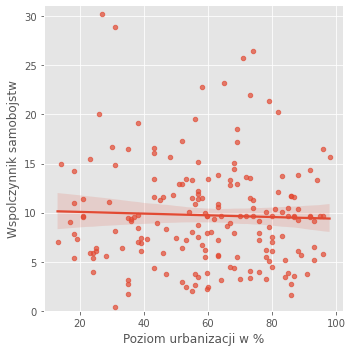

In [43]:

g = sns.lmplot(x = "Urbanizacja (%)", y = "wspolczynnik samobojstw", data = df, scatter_kws = {"s":20, "alpha":0.7})
g.set(xlabel = "Poziom urbanizacji w %", ylabel = "Wspolczynnik samobojstw")
g.set(ylim=(0, 31))
plt.savefig(fname=op.join("plots",'a_korelacji.png'),dpi=600,transparent=False)

W celu sprawdzenia, czy poziom urbanizacji kraju jest \
powiązany ze współczynnikiem samobójstw wykonano analizę korelacji r Pearsona.\
Wynik analizy okazał się nieistotny statystycznie, r = -0.04 ; p = 0.63. Nie ma związku pomiędzy zmiennymi.

### Regresja jednozmiennowa:
Przewidywanie średniej długości życia mieszkańców na podstawie ilości spożywanego mięsa.

In [44]:
def F(model, rnd = 2, prnd = 3):
    p = model.f_pvalue
    pFillIn = f"< 0.001" if p < 0.001 else f"= {np.around(p,prnd)}"
    return f"F({int(model.df_model)}, {int(model.df_resid)}) = {np.around(model.fvalue, rnd)} ; p {pFillIn}"

In [45]:
model = smf.ols(formula= 'Q("Przewidywana dlugosc zycia") ~ Q("Spozycie miesa")', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Q("Przewidywana dlugosc zycia")   R-squared:                       0.413
Model:                                         OLS   Adj. R-squared:                  0.409
Method:                              Least Squares   F-statistic:                     129.2
Date:                             Mon, 30 Jan 2023   Prob (F-statistic):           5.03e-23
Time:                                     12:56:11   Log-Likelihood:                -582.23
No. Observations:                              186   AIC:                             1168.
Df Residuals:                                  184   BIC:                             1175.
Df Model:                                        1                                         
Covariance Type:                         nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              66.0606      0.675     97.901      0.000      64.729      67.392
Q("Spozycie miesa")     0.1360      0.012     11.368      0.000       0.112       0.160
==============================================================================
Omnibus:                       10.201   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               10.611
Skew:                          -0.583   Prob(JB):                      0.00496
Kurtosis:                       3.092   Cond. No.                         93.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Y = 66.0606 + 0.1360 * Spozycie miesa

In [46]:
F(model)

'F(1, 184) = 129.23 ; p < 0.001'

In [47]:
df["Spozycie miesa"].min(), df["Spozycie miesa"].max()

(3.0, 145.9)

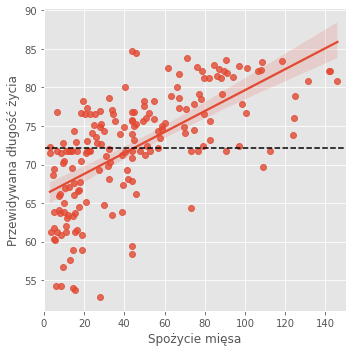

In [48]:
g = sns.lmplot(x="Spozycie miesa",y="Przewidywana dlugosc zycia",data=df)
plt.hlines(y = df["Przewidywana dlugosc zycia"].mean(), xmin = 0, xmax = 150, color = "k",
           linestyles="dashed")
g.set(xlabel = "Spożycie mięsa", ylabel = "Przewidywana długość życia")
plt.xlim(0, 150)
plt.savefig(fname=op.join("plots",'reg_jedn.png'),dpi=600,transparent=False)

W celu sprawdzenia, czy możemy przewidywać długość życia na podstawie ilości spożywanego mięsa, wykonano analizę regresji liniowej.\
Proponowany model pozwala na przewidywanie długości życia, F(1, 184) = 129.23 ; p < 0.001.\
Równanie regresji możemy zapisać za pomocą wzoru:\
Przewidywana długość życia = 66.06 + 0.14 * Spożycie mięsa. \
Model ten wyjaśnia 41.3% wariancji przewidywanej długości życia.

## Podsumowanie

- Ludzie zamieszkujący w krajach małych jedzą mniej mięsa niż osoby zamieszkujące kraje duże (test t Studenta dla prób niezależnych).
- Kraje znajdujące się w Afryce mają wyższy współczynnik dzietności niż Europa oraz Azja. Azja również wykazuje wyższy współczynnik dzietności niż Europa (jednoczynnikowa analiza wariancji w schemacie międzygrupowym).
- Poziom urbanizacji nie jest powiązany ze współczynnikiem samobójstw w kraju (analiza korelacji).
- Możemy przewidywać średnią długość życia mieszkańców kraju na podstawie średniej ilości spożywanego przez nich mięsa (analiza regresji liniowej).